In [10]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, STOPWORDS
import nltk
nltk.download("wordnet")

from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases

import crear_modelo_config

if __name__ == "__main__":
    ml_dataset = pd.read_csv("TweetsTrainDev.csv")
    ml_dataset.drop(ml_dataset[ml_dataset["airline"] != "United"].index, inplace = True)
    ml_dataset.drop(ml_dataset[ml_dataset["airline_sentiment"] != "negative"].index, inplace = True)

    docs = list(ml_dataset["text"])
    original_docs = docs[:]
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')

    stopwords = STOPWORDS.union(frozenset(["ua", "we", "on", "me", "you"])).difference(["kg", "before", "over", "system", "serious", "off", "take", "nowhere", "found"])
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = remove_stopwords(docs[idx], STOPWORDS)
        docs[idx] = strip_punctuation(docs[idx])
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words."""

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)


    # Set training parameters.
    num_topics = 12
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    diccionarios = []
    models = []
    for i in range(3, 50, 3):
        # Create a dictionary representation of the documents.
        dictionary = Dictionary(docs)

        # Filter out words that occur less than 20 documents, or more than 50% of the documents.
        dictionary.filter_extremes(no_below=i, no_above=0.1)

        # Bag-of-words representation of the documents.
        corpus = [dictionary.doc2bow(doc) for doc in docs]

        print('Number of unique tokens: %d' % len(dictionary))
        print('Number of documents: %d' % len(corpus))

        # Make an index to word dictionary.
        temp = dictionary[0]  # This is only to "load" the dictionary.
        id2word = dictionary.id2token
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every # type: ignore
        )
        models.append(model)

        #diccionario = Dictionary(ml_dataset.Tokens)

        diccionarios.append(dictionary)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Number of unique tokens: 1424
Number of documents: 2633
Number of unique tokens: 748
Number of documents: 2633
Number of unique tokens: 533
Number of documents: 2633
Number of unique tokens: 412
Number of documents: 2633
Number of unique tokens: 332
Number of documents: 2633
Number of unique tokens: 272
Number of documents: 2633
Number of unique tokens: 235
Number of documents: 2633
Number of unique tokens: 204
Number of documents: 2633
Number of unique tokens: 174
Number of documents: 2633
Number of unique tokens: 156
Number of documents: 2633
Number of unique tokens: 138
Number of documents: 2633
Number of unique tokens: 122
Number of documents: 2633
Number of unique tokens: 115
Number of documents: 2633
Number of unique tokens: 99
Number of documents: 2633
Number of unique tokens: 88
Number of documents: 2633
Number of unique tokens: 80
Number of documents: 2633


In [11]:
print(len(models))
print(len(diccionarios))

16
16


In [12]:
coherences = []
num_docs_arr = []

num_docs = 3
for (model, dictionary) in zip(models, diccionarios):
        top_topics = model.top_topics(texts=docs, dictionary=dictionary, coherence="c_v")
        # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
        avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
        #print('Average topic coherence: %.4f.' % avg_topic_coherence)

        coherences.append(avg_topic_coherence)
        num_docs_arr.append(num_docs)
        print(f"num_docs: {num_docs}, avg_coherence: {avg_topic_coherence}")
        num_docs += 3

num_topics: 3, avg_coherence: 0.3048656637019734
num_topics: 6, avg_coherence: 0.3117183484854416
num_topics: 9, avg_coherence: 0.3224084716178566
num_topics: 12, avg_coherence: 0.345653173253401
num_topics: 15, avg_coherence: 0.31869925523227965
num_topics: 18, avg_coherence: 0.3197467143450161
num_topics: 21, avg_coherence: 0.3051753006850714
num_topics: 24, avg_coherence: 0.30758885773477385
num_topics: 27, avg_coherence: 0.3124657288097028
num_topics: 30, avg_coherence: 0.27864023667988663
num_topics: 33, avg_coherence: 0.2678419174611402
num_topics: 36, avg_coherence: 0.2505866332642709
num_topics: 39, avg_coherence: 0.25863431510776375
num_topics: 42, avg_coherence: 0.2531899315048538
num_topics: 45, avg_coherence: 0.22364516948950156
num_topics: 48, avg_coherence: 0.22891421109947743


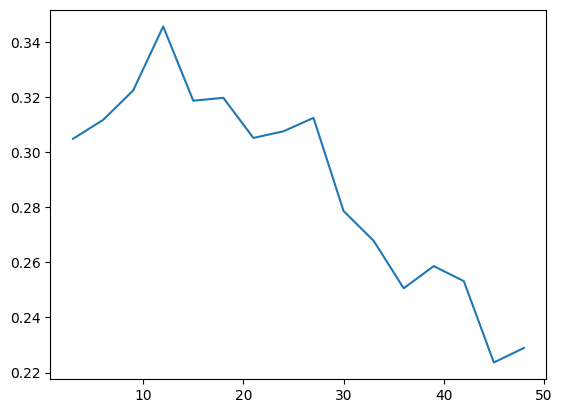

In [13]:

import matplotlib.pyplot as plt
import numpy as np

valores = np.array(coherences)
etiquetas = np.array(num_docs_arr)

plt.plot(etiquetas, valores)
plt.show()
